<a href="https://www.kaggle.com/code/iwways/insurance-premiums-unlocked-train-like-a-pro?scriptVersionId=215417862" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Introduction

Hi!
This is new playground competition and in this month we're having an insurance dataset. 

Before diving deeper into code, let's describe a little topic in which we will work.

For start, a little meme which describes all this thing :)

![](https://leadsurance.com/wp-content/uploads/2020/08/insurance-meme-6.jpg)


In my previous notebook I was combined EDA and training
https://www.kaggle.com/code/iwways/calculating-premiums-like-a-pro-or-not

But I decided to make training in separate notebook, cause a lot of things is going here :)

# Import libraries

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
import pandas as pd
import missingno as mnso
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import boxcox
from scipy.special import boxcox1p
from sklearn.model_selection import cross_val_score, StratifiedKFold
# To ignore warinings
import warnings
warnings.filterwarnings('ignore')

# Load data

In [2]:
X_train = pd.read_csv('/kaggle/input/playground-series-s4e12/train.csv')
X_test = pd.read_csv('/kaggle/input/playground-series-s4e12/test.csv')
sample_submission = pd.read_csv('/kaggle/input/playground-series-s4e12/sample_submission.csv')

X_train = X_train.drop(['id'], axis=1)

id_test = X_test.id
X_test = X_test.drop('id', axis=1)

# y = X_train['Premium Amount']
# y_log = np.log1p(y)

pd.set_option('display.max_columns', None)


After exploring discussions it seems reasonable to log transform our target variable to ensure that we optimizing directly the evaluation metric for this competition

# Feature enginereering

# Log Transformation of Annual Income

In [3]:
X_train['Annual Income'] = np.log1p(X_train['Annual Income'])
X_test['Annual Income'] = np.log1p(X_test['Annual Income'])

It's will be useful if we separate Policy Start Date feature to different features, as day, month and other.

## Time features

In [4]:
X_train

,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount
0,19.0,Female,9.215328,Married,1.0,Bachelor's,Self-Employed,22.598761,Urban,Premium,2.0,17.0,372.0,5.0,2023-12-23 15:21:39.134960,Poor,No,Weekly,House,2869.0
1,39.0,Female,10.363409,Divorced,3.0,Master's,NaN,15.569731,Rural,Comprehensive,1.0,12.0,694.0,2.0,2023-06-12 15:21:39.111551,Average,Yes,Monthly,House,1483.0
2,23.0,Male,10.150465,Divorced,3.0,High School,Self-Employed,47.177549,Suburban,Premium,1.0,14.0,NaN,3.0,2023-09-30 15:21:39.221386,Good,Yes,Weekly,House,567.0
3,21.0,Male,11.862568,Married,2.0,Bachelor's,NaN,10.938144,Rural,Basic,1.0,0.0,367.0,1.0,2024-06-12 15:21:39.226954,Poor,Yes,Daily,Apartment,765.0
4,21.0,Male,10.587897,Single,1.0,Bachelor's,Self-Employed,20.376094,Rural,Premium,0.0,8.0,598.0,4.0,2021-12-01 15:21:39.252145,Poor,Yes,Weekly,House,2022.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1199995,36.0,Female,10.215264,Married,0.0,Master's,Unemployed,13.772907,Urban,Premium,NaN,5.0,372.0,3.0,2023-05-03 15:21:39.257696,Poor,No,Daily,Apartment,1303.0
1199996,54.0,Male,10.485340,Divorced,NaN,Master's,Self-Employed,11.483482,Rural,Comprehensive,NaN,10.0,597.0,4.0,2022-09-10 15:21:39.134960,Poor,No,Weekly,Apartment,821.0
1199997,19.0,Male,10.856785,Divorced,0.0,Master's,NaN,14.724469,Suburban,Basic,0.0,19.0,NaN,6.0,2021-05-25 15:21:39.106582,Good,No,Monthly,Condo,371.0
1199998,55.0,Male,NaN,Single,1.0,PhD,NaN,18.547381,Suburban,Premium,1.0,7.0,407.0,4.0,2021-09-19 15:21:39.190215,Poor,No,Daily,Apartment,596.0


In [5]:
def create_policy_start_date_separated_features(df):
    df['Policy Start Date'] = pd.to_datetime(df['Policy Start Date'], errors='coerce')
    df['Policy_Start_Year'] = df['Policy Start Date'].dt.year
    df['Policy_Start_Month'] = df['Policy Start Date'].dt.month
    df['Policy_Start_Day'] = df['Policy Start Date'].dt.day
    

    return df


In [6]:
import numpy as np
import pandas as pd

def circular_features_time(df, date_column='Policy Start Date'):
    df[date_column] = pd.to_datetime(df[date_column])
    
    df['day_of_week'] = df[date_column].dt.dayofweek
    df['day_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['day_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
    
    df['day_of_year'] = df[date_column].dt.dayofyear
    df['year_day_sin'] = np.sin(2 * np.pi * df['day_of_year'] / 365)
    df['year_day_cos'] = np.cos(2 * np.pi * df['day_of_year'] / 365)
    
    df['month'] = df[date_column].dt.month
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    
    df["seconds_since_1970"] = df[date_column].astype("int64") // 10**9
    df = df.drop('Policy Start Date', axis=1)

    return df

    

In [7]:
train = create_policy_start_date_separated_features(X_train)
test = create_policy_start_date_separated_features(X_test)

train = circular_features_time(X_train)
test = circular_features_time(X_test)

In [8]:
train

,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount,Policy_Start_Year,Policy_Start_Month,Policy_Start_Day,day_of_week,day_sin,day_cos,day_of_year,year_day_sin,year_day_cos,month,month_sin,month_cos,seconds_since_1970
0,19.0,Female,9.215328,Married,1.0,Bachelor's,Self-Employed,22.598761,Urban,Premium,2.0,17.0,372.0,5.0,Poor,No,Weekly,House,2869.0,2023,12,23,5,-0.974928,-0.222521,357,-0.137279,0.990532,12,-2.449294e-16,1.000000e+00,1703344899
1,39.0,Female,10.363409,Divorced,3.0,Master's,NaN,15.569731,Rural,Comprehensive,1.0,12.0,694.0,2.0,Average,Yes,Monthly,House,1483.0,2023,6,12,0,0.000000,1.000000,163,0.329408,-0.944188,6,1.224647e-16,-1.000000e+00,1686583299
2,23.0,Male,10.150465,Divorced,3.0,High School,Self-Employed,47.177549,Suburban,Premium,1.0,14.0,NaN,3.0,Good,Yes,Weekly,House,567.0,2023,9,30,5,-0.974928,-0.222521,273,-0.999917,-0.012910,9,-1.000000e+00,-1.836970e-16,1696087299
3,21.0,Male,11.862568,Married,2.0,Bachelor's,NaN,10.938144,Rural,Basic,1.0,0.0,367.0,1.0,Poor,Yes,Daily,Apartment,765.0,2024,6,12,2,0.974928,-0.222521,164,0.313107,-0.949718,6,1.224647e-16,-1.000000e+00,1718205699
4,21.0,Male,10.587897,Single,1.0,Bachelor's,Self-Employed,20.376094,Rural,Premium,0.0,8.0,598.0,4.0,Poor,Yes,Weekly,House,2022.0,2021,12,1,2,0.974928,-0.222521,335,-0.493776,0.869589,12,-2.449294e-16,1.000000e+00,1638372099
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1199995,36.0,Female,10.215264,Married,0.0,Master's,Unemployed,13.772907,Urban,Premium,NaN,5.0,372.0,3.0,Poor,No,Daily,Apartment,1303.0,2023,5,3,2,0.974928,-0.222521,123,0.854322,-0.519744,5,5.000000e-01,-8.660254e-01,1683127299
1199996,54.0,Male,10.485340,Divorced,NaN,Master's,Self-Employed,11.483482,Rural,Comprehensive,NaN,10.0,597.0,4.0,Poor,No,Weekly,Apartment,821.0,2022,9,10,5,-0.974928,-0.222521,253,-0.936881,-0.349647,9,-1.000000e+00,-1.836970e-16,1662823299
1199997,19.0,Male,10.856785,Divorced,0.0,Master's,NaN,14.724469,Suburban,Basic,0.0,19.0,NaN,6.0,Good,No,Monthly,Condo,371.0,2021,5,25,1,0.781831,0.623490,145,0.601624,-0.798779,5,5.000000e-01,-8.660254e-01,1621956099
1199998,55.0,Male,NaN,Single,1.0,PhD,NaN,18.547381,Suburban,Premium,1.0,7.0,407.0,4.0,Poor,No,Daily,Apartment,596.0,2021,9,19,6,-0.781831,0.623490,262,-0.979614,-0.200891,9,-1.000000e+00,-1.836970e-16,1632064899


In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200000 entries, 0 to 1199999
Data columns (total 32 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   Age                   1181295 non-null  float64
 1   Gender                1200000 non-null  object 
 2   Annual Income         1155051 non-null  float64
 3   Marital Status        1181471 non-null  object 
 4   Number of Dependents  1090328 non-null  float64
 5   Education Level       1200000 non-null  object 
 6   Occupation            841925 non-null   object 
 7   Health Score          1125924 non-null  float64
 8   Location              1200000 non-null  object 
 9   Policy Type           1200000 non-null  object 
 10  Previous Claims       835971 non-null   float64
 11  Vehicle Age           1199994 non-null  float64
 12  Credit Score          1062118 non-null  float64
 13  Insurance Duration    1199999 non-null  float64
 14  Customer Feedback     1122176 non-

## Handling missing values TODO

After Chris's Deotte post i decided not to impute values for NaN's, so let's check how our results will be.

UPD: adding an column indicator for missing values

In [10]:
def impute_missing_numerical_data(df):
    num = ['Age', 'Annual Income', 'Number of Dependents', 'Health Score',
       'Previous Claims', 'Vehicle Age', 'Credit Score', 'Insurance Duration']
    for n in num:
        df[f"is_{n}_na"] = df[n].isna()
        df[n] = df[n].fillna(df[n].mean())

    return df

def impute_missing_categorical_data(df):
    cat = ['Marital Status', 'Occupation', 'Customer Feedback']
    for c in cat:
        df[f"is_{c}_na"] = df[c].isna()
        df[c] = df[c].fillna(df[c].mode())

    return df

In [11]:
train = impute_missing_categorical_data(train)
test = impute_missing_categorical_data(test)

In [12]:
train = impute_missing_numerical_data(train)
test = impute_missing_numerical_data(test)

In [13]:
train

,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount,Policy_Start_Year,Policy_Start_Month,Policy_Start_Day,day_of_week,day_sin,day_cos,day_of_year,year_day_sin,year_day_cos,month,month_sin,month_cos,seconds_since_1970,is_Marital Status_na,is_Occupation_na,is_Customer Feedback_na,is_Age_na,is_Annual Income_na,is_Number of Dependents_na,is_Health Score_na,is_Previous Claims_na,is_Vehicle Age_na,is_Credit Score_na,is_Insurance Duration_na
0,19.0,Female,9.215328,Married,1.000000,Bachelor's,Self-Employed,22.598761,Urban,Premium,2.000000,17.0,372.00000,5.0,Poor,No,Weekly,House,2869.0,2023,12,23,5,-0.974928,-0.222521,357,-0.137279,0.990532,12,-2.449294e-16,1.000000e+00,1703344899,False,False,False,False,False,False,False,False,False,False,False
1,39.0,Female,10.363409,Divorced,3.000000,Master's,NaN,15.569731,Rural,Comprehensive,1.000000,12.0,694.00000,2.0,Average,Yes,Monthly,House,1483.0,2023,6,12,0,0.000000,1.000000,163,0.329408,-0.944188,6,1.224647e-16,-1.000000e+00,1686583299,False,True,False,False,False,False,False,False,False,False,False
2,23.0,Male,10.150465,Divorced,3.000000,High School,Self-Employed,47.177549,Suburban,Premium,1.000000,14.0,592.92435,3.0,Good,Yes,Weekly,House,567.0,2023,9,30,5,-0.974928,-0.222521,273,-0.999917,-0.012910,9,-1.000000e+00,-1.836970e-16,1696087299,False,False,False,False,False,False,False,False,False,True,False
3,21.0,Male,11.862568,Married,2.000000,Bachelor's,NaN,10.938144,Rural,Basic,1.000000,0.0,367.00000,1.0,Poor,Yes,Daily,Apartment,765.0,2024,6,12,2,0.974928,-0.222521,164,0.313107,-0.949718,6,1.224647e-16,-1.000000e+00,1718205699,False,True,False,False,False,False,False,False,False,False,False
4,21.0,Male,10.587897,Single,1.000000,Bachelor's,Self-Employed,20.376094,Rural,Premium,0.000000,8.0,598.00000,4.0,Poor,Yes,Weekly,House,2022.0,2021,12,1,2,0.974928,-0.222521,335,-0.493776,0.869589,12,-2.449294e-16,1.000000e+00,1638372099,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1199995,36.0,Female,10.215264,Married,0.000000,Master's,Unemployed,13.772907,Urban,Premium,1.002689,5.0,372.00000,3.0,Poor,No,Daily,Apartment,1303.0,2023,5,3,2,0.974928,-0.222521,123,0.854322,-0.519744,5,5.000000e-01,-8.660254e-01,1683127299,False,False,False,False,False,False,False,True,False,False,False
1199996,54.0,Male,10.485340,Divorced,2.009934,Master's,Self-Employed,11.483482,Rural,Comprehensive,1.002689,10.0,597.00000,4.0,Poor,No,Weekly,Apartment,821.0,2022,9,10,5,-0.974928,-0.222521,253,-0.936881,-0.349647,9,-1.000000e+00,-1.836970e-16,1662823299,False,False,False,False,False,True,False,True,False,False,False
1199997,19.0,Male,10.856785,Divorced,0.000000,Master's,NaN,14.724469,Suburban,Basic,0.000000,19.0,592.92435,6.0,Good,No,Monthly,Condo,371.0,2021,5,25,1,0.781831,0.623490,145,0.601624,-0.798779,5,5.000000e-01,-8.660254e-01,1621956099,False,True,False,False,False,False,False,False,False,True,False
1199998,55.0,Male,9.767484,Single,1.000000,PhD,NaN,18.547381,Suburban,Premium,1.000000,7.0,407.00000,4.0,Poor,No,Daily,Apartment,596.0,2021,9,19,6,-0.781831,0.623490,262,-0.979614,-0.200891,9,-1.000000e+00,-1.836970e-16,1632064899,False,True,False,False,True,False,False,False,False,False,False


In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200000 entries, 0 to 1199999
Data columns (total 43 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   Age                         1200000 non-null  float64
 1   Gender                      1200000 non-null  object 
 2   Annual Income               1200000 non-null  float64
 3   Marital Status              1181471 non-null  object 
 4   Number of Dependents        1200000 non-null  float64
 5   Education Level             1200000 non-null  object 
 6   Occupation                  841925 non-null   object 
 7   Health Score                1200000 non-null  float64
 8   Location                    1200000 non-null  object 
 9   Policy Type                 1200000 non-null  object 
 10  Previous Claims             1200000 non-null  float64
 11  Vehicle Age                 1200000 non-null  float64
 12  Credit Score                1200000 non-null  float64
 1

## Scaling numerical features

In [15]:
num_cols = X_train.select_dtypes(exclude=['object', 'datetime', 'bool']).columns.tolist()
num_cols.remove('Premium Amount')
cat_cols = X_train.select_dtypes(include='object').columns.tolist()

scaler = StandardScaler()

X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

In [16]:
X_train[num_cols]

,Age,Annual Income,Number of Dependents,Health Score,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy_Start_Year,Policy_Start_Month,Policy_Start_Day,day_of_week,day_sin,day_cos,day_of_year,year_day_sin,year_day_cos,month,month_sin,month_cos,seconds_since_1970
0,-1.635573,-0.407929,-0.712557,-0.247073,1.014724,1.286335,-1.473007,-0.007023,0.934365,1.604378,0.827741,1.001791,-1.380587,-0.319045,1.666315,-0.203630,1.412794,1.604378,-0.002224,1.428703,1.301065
1,-0.158462,0.440264,0.698540,-0.823060,-0.002736,0.420712,0.673919,-1.163391,0.934365,-0.143523,-0.420596,-1.495354,-0.002679,1.410947,-0.183316,0.454634,-1.330777,-0.143523,-0.002224,-1.403181,0.929018
2,-1.340151,0.282943,0.698540,1.767011,-0.002736,0.766961,NaN,-0.777935,0.934365,0.730427,1.622137,1.001791,-1.380587,-0.319045,0.865444,-1.420384,-0.010159,0.730427,-1.414833,0.012761,1.139973
3,-1.487862,1.547830,-0.007009,-1.202591,-0.002736,-1.656783,-1.506344,-1.548846,1.611868,-0.143523,-0.420596,-0.496496,1.375230,-0.319045,-0.173782,0.431641,-1.338619,-0.143523,-0.002224,-1.403181,1.630921
4,-1.487862,0.606114,-0.712557,-0.429207,-1.020196,-0.271786,0.033842,-0.392479,-0.420641,1.604378,-1.668933,-0.496496,1.375230,-0.319045,1.456563,-0.706470,1.241288,1.604378,-0.002224,1.428703,-0.141095
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1199995,-0.380028,0.330816,-1.418106,-0.970299,NaN,-0.791160,-1.473007,-0.777935,0.934365,-0.434840,-1.441963,-0.496496,1.375230,-0.319045,-0.564683,1.195027,-0.728885,-0.434840,0.704081,-1.213480,0.852308
1199996,0.949371,0.530346,NaN,-1.157904,NaN,0.074463,0.027174,-0.392479,0.256862,0.730427,-0.647567,1.001791,-1.380587,-0.319045,0.674760,-1.331473,-0.487677,0.730427,-1.414833,0.012761,0.401632
1199997,-1.635573,0.804766,-1.418106,-0.892324,-1.020196,1.632584,NaN,0.378433,-0.420641,-0.434840,1.054711,-0.995925,1.102318,0.878146,-0.354931,0.838595,-1.124578,-0.434840,0.704081,-1.213480,-0.505471
1199998,1.023227,NaN,-0.712557,-0.579059,-0.002736,-0.444911,-1.239645,-0.392479,-0.420641,0.730427,0.373800,1.501221,-1.107675,0.878146,0.760568,-1.391747,-0.276729,0.730427,-1.414833,0.012761,-0.281092


## Encoding categorical features

Now it's time for encoding!

In [17]:
def encode_ordinal(df):
    educ = {"High School":0, "Bachelor's":1, "Master's":2, "PhD":3}
    policy = {'Basic':0, 'Comprehensive':1, 'Premium':2}
    exerc = {'Rarely':0, 'Daily':1, 'Weekly':2, 'Monthly': 3}
    feedback = {'Poor':0, 'Average':1, 'Good':2, "Unknown": 0}

    df['Education Level'] = df['Education Level'].map(educ)
    df['Policy Type'] = df['Policy Type'].map(policy)
    df['Exercise Frequency'] = df['Exercise Frequency'].map(exerc)
    df['Customer Feedback'] = df['Customer Feedback'].map(feedback)
    return df

In [18]:
def encode_binary(df):
    df['Gender'] = df['Gender'].map({'Male':0, 'Female':1})
    df['Smoking Status'] = df['Smoking Status'].map({'Yes':1, 'No':0})
    return df

In [19]:
def one_hot_dummies(df, categorical):
    oh = pd.get_dummies(df[categorical])
    df = df.drop(categorical, axis=1)
    return pd.concat([df, oh], axis=1)

In [20]:
y = X_train['Premium Amount']
train = train.drop('Premium Amount', axis=1)
y_log = np.log1p(y)

In [21]:
train = encode_binary(train)
test = encode_binary(test)

In [22]:
train = encode_ordinal(train)
test = encode_ordinal(test)

In [23]:
train

,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Policy_Start_Year,Policy_Start_Month,Policy_Start_Day,day_of_week,day_sin,day_cos,day_of_year,year_day_sin,year_day_cos,month,month_sin,month_cos,seconds_since_1970,is_Marital Status_na,is_Occupation_na,is_Customer Feedback_na,is_Age_na,is_Annual Income_na,is_Number of Dependents_na,is_Health Score_na,is_Previous Claims_na,is_Vehicle Age_na,is_Credit Score_na,is_Insurance Duration_na
0,19.0,1,9.215328,Married,1.000000,1,Self-Employed,22.598761,Urban,2,2.000000,17.0,372.00000,5.0,0.0,0,2,House,2023,12,23,5,-0.974928,-0.222521,357,-0.137279,0.990532,12,-2.449294e-16,1.000000e+00,1703344899,False,False,False,False,False,False,False,False,False,False,False
1,39.0,1,10.363409,Divorced,3.000000,2,NaN,15.569731,Rural,1,1.000000,12.0,694.00000,2.0,1.0,1,3,House,2023,6,12,0,0.000000,1.000000,163,0.329408,-0.944188,6,1.224647e-16,-1.000000e+00,1686583299,False,True,False,False,False,False,False,False,False,False,False
2,23.0,0,10.150465,Divorced,3.000000,0,Self-Employed,47.177549,Suburban,2,1.000000,14.0,592.92435,3.0,2.0,1,2,House,2023,9,30,5,-0.974928,-0.222521,273,-0.999917,-0.012910,9,-1.000000e+00,-1.836970e-16,1696087299,False,False,False,False,False,False,False,False,False,True,False
3,21.0,0,11.862568,Married,2.000000,1,NaN,10.938144,Rural,0,1.000000,0.0,367.00000,1.0,0.0,1,1,Apartment,2024,6,12,2,0.974928,-0.222521,164,0.313107,-0.949718,6,1.224647e-16,-1.000000e+00,1718205699,False,True,False,False,False,False,False,False,False,False,False
4,21.0,0,10.587897,Single,1.000000,1,Self-Employed,20.376094,Rural,2,0.000000,8.0,598.00000,4.0,0.0,1,2,House,2021,12,1,2,0.974928,-0.222521,335,-0.493776,0.869589,12,-2.449294e-16,1.000000e+00,1638372099,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1199995,36.0,1,10.215264,Married,0.000000,2,Unemployed,13.772907,Urban,2,1.002689,5.0,372.00000,3.0,0.0,0,1,Apartment,2023,5,3,2,0.974928,-0.222521,123,0.854322,-0.519744,5,5.000000e-01,-8.660254e-01,1683127299,False,False,False,False,False,False,False,True,False,False,False
1199996,54.0,0,10.485340,Divorced,2.009934,2,Self-Employed,11.483482,Rural,1,1.002689,10.0,597.00000,4.0,0.0,0,2,Apartment,2022,9,10,5,-0.974928,-0.222521,253,-0.936881,-0.349647,9,-1.000000e+00,-1.836970e-16,1662823299,False,False,False,False,False,True,False,True,False,False,False
1199997,19.0,0,10.856785,Divorced,0.000000,2,NaN,14.724469,Suburban,0,0.000000,19.0,592.92435,6.0,2.0,0,3,Condo,2021,5,25,1,0.781831,0.623490,145,0.601624,-0.798779,5,5.000000e-01,-8.660254e-01,1621956099,False,True,False,False,False,False,False,False,False,True,False
1199998,55.0,0,9.767484,Single,1.000000,3,NaN,18.547381,Suburban,2,1.000000,7.0,407.00000,4.0,0.0,0,1,Apartment,2021,9,19,6,-0.781831,0.623490,262,-0.979614,-0.200891,9,-1.000000e+00,-1.836970e-16,1632064899,False,True,False,False,True,False,False,False,False,False,False


In [24]:
numerical_features_total = test.select_dtypes(exclude='object').columns
numerical_features_continuos = test.select_dtypes(exclude=['object', 'int']).columns
numerical_features_discrete = test.select_dtypes(exclude=['object', 'float']).columns
categorical_features = test.select_dtypes(include='object').columns

In [25]:
categorical_features

Index(['Marital Status', 'Occupation', 'Location', 'Property Type'], dtype='object')

In [26]:
train_enc = one_hot_dummies(train, categorical_features)
test_enc = one_hot_dummies(test, categorical_features)

## Feature selection

Saving some samples for latter to evaluate perfomance

In [27]:
# train_enc, X_test_separated, y_log, y_test_separated = train_test_split(train_enc, y_log, test_size=0.15, random_state=42)

## Some new features

In [28]:
def add_new_features(df):
    df['Income to Dependents Ratio'] = df['Annual Income'] / (df['Number of Dependents'].fillna(0) + 1)
    df['Income_per_Dependent'] = df['Annual Income'] / (df['Number of Dependents'] + 1)
    df['CreditScore_InsuranceDuration'] = df['Credit Score'] * df['Insurance Duration']
    df['Health_Risk_Score'] = df['Smoking Status'].apply(lambda x: 1 if x == 'Smoker' else 0) + \
                                df['Exercise Frequency'].apply(lambda x: 1 if x == 'Low' else (0.5 if x == 'Medium' else 0)) + \
                                (100 - df['Health Score']) / 20
    df['Credit_Health_Score'] = df['Credit Score'] * df['Health Score']
    df['Health_Age_Interaction'] = df['Health Score'] * df['Age']
    return df

train_enc = add_new_features(train_enc)
test_enc = add_new_features(test_enc)

# Training model

In [29]:
def rmsle(y_true, y_pred):
    
    log_true = np.log1p(y_true)  # log(1 + y_true)
    log_pred = np.log1p(y_pred)  # log(1 + y_pred)

    return np.sqrt(mean_squared_error(log_true, log_pred))


In [30]:
#experiment with feauture selection (Annual Income, Policy Type, Health Score)
def select_important_features(df, columns = ['Annual Income', 'Policy Type', 'Health Score']):
    return df[columns]

In [31]:
# train_enc = select_important_features(train_enc)
# test_enc = select_important_features(test_enc)

In [32]:
x_train, x_val, y_train, y_val = train_test_split(train_enc, y_log, test_size=0.10, random_state=42)

## Get in hand with Optuna

In [33]:
import optuna
from sklearn.ensemble import HistGradientBoostingRegressor as hgbc

In [34]:
from sklearn.metrics import make_scorer

def rmsle_on_original_scale(y_true, y_pred):
    y_true = np.expm1(y_true)
    y_pred = np.expm1(y_pred)
    
    y_pred = np.maximum(y_pred, np.min(y_true))
    
    log_true = np.log1p(y_true)
    log_pred = np.log1p(y_pred)
    return np.sqrt(np.mean((log_true - log_pred) ** 2))

rmsle_scorer = make_scorer(rmsle_on_original_scale, greater_is_better=False)

## XGBoost Regressor

In [35]:
import xgboost as xgb

In [36]:
def objective_xgb(trial):
    # params = {
    #     'n_estimators': trial.suggest_int('n_estimators', 20, 500),
    #     'max_depth': int(trial.suggest_float('max_depth', 1, 100, log=True)),
    #     'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
    #     'booster': trial.suggest_categorical('booster', ['gbtree', 'gblinear', 'dart']),
    #     'gamma': trial.suggest_float('gamma', 0, 2),
    #     'max_delta_step': trial.suggest_float('max_delta_step', 0, 10),
    #     'subsample': trial.suggest_float('subsample', 0, 1)
    # }

    params = {        
            "n_estimators": trial.suggest_int("n_estimators", 50, 1000, step=100),
            "max_depth":trial.suggest_int("max_depth", 4, 10),
            "min_child_weight": trial.suggest_int("min_child_weight", 7, 8),
            "learning_rate": trial.suggest_float("learning_rate", 1e-4, 1e-1, log=True), 
            "subsample": trial.suggest_float("subsample", 0.7, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.1, 1.0),
            "reg_alpha": trial.suggest_float("reg_alpha", 1e-2, 10.),
            "reg_lambda": trial.suggest_float("reg_lambda", 1e-2, 10.),
            "gamma": trial.suggest_float("gamma", 0.7, 1.0, step=0.1),
    }    
    
    xgb_model = xgb.XGBRegressor(verbosity = 0, device='gpu', objective = 'reg:squarederror', tree_method='gpu_hist', **params)

    return -1*cross_val_score(xgb_model, x_train, y_train, n_jobs=-1, cv=3, scoring=rmsle_scorer).mean()

# study = optuna.create_study(direction='minimize')
# study.optimize(objective_xgb, n_trials=100)
# trial = study.best_trial

In [37]:
# print('Accuracy: {}'.format(trial.value))

# print("Best hyperparameters: {}".format(trial.params)) 

In [38]:
params = {'n_estimators': 950, 'max_depth': 9, 'min_child_weight': 8, 'learning_rate': 0.005157092015323985, 'subsample': 0.8137283875432285, 'colsample_bytree': 0.9983658272411838, 'reg_alpha': 6.517426484808757, 'reg_lambda': 0.8771067924995002, 'gamma': 0.7}
xgb_model = xgb.XGBRegressor(verbosity = 0, device='gpu', objective = 'reg:squarederror', tree_method='gpu_hist', **params)
xgb_model.fit(x_train, y_train, eval_set=[(x_val, y_val)])

[0]	validation_0-rmse:1.09564
[1]	validation_0-rmse:1.09516
[2]	validation_0-rmse:1.09468
[3]	validation_0-rmse:1.09420
[4]	validation_0-rmse:1.09373
[5]	validation_0-rmse:1.09326
[6]	validation_0-rmse:1.09280
[7]	validation_0-rmse:1.09234
[8]	validation_0-rmse:1.09189
[9]	validation_0-rmse:1.09144
[10]	validation_0-rmse:1.09100
[11]	validation_0-rmse:1.09056
[12]	validation_0-rmse:1.09013
[13]	validation_0-rmse:1.08970
[14]	validation_0-rmse:1.08927
[15]	validation_0-rmse:1.08896
[16]	validation_0-rmse:1.08854
[17]	validation_0-rmse:1.08813
[18]	validation_0-rmse:1.08782
[19]	validation_0-rmse:1.08741
[20]	validation_0-rmse:1.08703
[21]	validation_0-rmse:1.08662
[22]	validation_0-rmse:1.08623
[23]	validation_0-rmse:1.08584
[24]	validation_0-rmse:1.08545
[25]	validation_0-rmse:1.08507
[26]	validation_0-rmse:1.08469
[27]	validation_0-rmse:1.08431
[28]	validation_0-rmse:1.08393
[29]	validation_0-rmse:1.08356
[30]	validation_0-rmse:1.08320
[31]	validation_0-rmse:1.08284
[32]	validation_0-

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9983658272411838, device='gpu',
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0.7, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.005157092015323985, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=8, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=950, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [39]:
pred_xgb = np.expm1(xgb_model.predict(x_val))
y_val_true = np.expm1(y_val)
train_min = y_train.min()
clipped_predictions = np.maximum(pred_xgb, train_min)

print(rmsle(y_val_true, pred_xgb)) 

1.0461923309290613


## LightGBM Regressor

In [40]:
import lightgbm as light


In [41]:
def objective_light(trial):
    # params = {
    #     'n_estimators': trial.suggest_int('n_estimators', 20, 500),
    #     'max_depth': int(trial.suggest_float('max_depth', 1, 100, log=True)),
    #     'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
    #     'booster': trial.suggest_categorical('booster', ['gbtree', 'gblinear', 'dart']),
    #     'gamma': trial.suggest_float('gamma', 0, 2),
    #     'max_delta_step': trial.suggest_float('max_delta_step', 0, 10),
    #     'subsample': trial.suggest_float('subsample', 0, 1)
    # }

    params = {        
            "n_estimators": trial.suggest_int("n_estimators", 50, 1000, step=100),
            "max_depth":trial.suggest_int("max_depth", 4, 10),
            "min_child_weight": trial.suggest_int("min_child_weight", 7, 8),
            "learning_rate": trial.suggest_float("learning_rate", 1e-4, 1e-1, log=True), 
            "subsample": trial.suggest_float("subsample", 0.7, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.1, 1.0),
            "reg_alpha": trial.suggest_float("reg_alpha", 1e-2, 10.),
            "reg_lambda": trial.suggest_float("reg_lambda", 1e-2, 10.),
            "num_leaves": trial.suggest_int("num_leaves", 2^4+1, 2^10+1)
    }    
    
    light_model = light.LGBMRegressor(verbosity = 0, device='gpu', **params)

    return -1*cross_val_score(light_model, x_train, y_train, n_jobs=-1, cv=3, scoring=rmsle_scorer).mean()

# study = optuna.create_study(direction='minimize')
# study.optimize(objective_light, n_trials=100)
# trial = study.best_trial

In [42]:
# print('Accuracy: {}'.format(trial.value))

# print("Best hyperparameters: {}".format(trial.params)) 

In [43]:
params = {'n_estimators': 550, 'max_depth': 10, 'min_child_weight': 8, 'learning_rate': 0.08399292742344162, 'subsample': 0.9931188111029522, 'colsample_bytree': 0.9549872057382064, 'reg_alpha': 9.447214278486067, 'reg_lambda': 9.191170124319523, 'num_leaves': 9}
light_model = light.LGBMRegressor(**params, verbose=0, device='gpu')
light_model.fit(x_train, y_train, eval_set=[(x_val, y_val)])

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


LGBMRegressor(colsample_bytree=0.9549872057382064, device='gpu',
              learning_rate=0.08399292742344162, max_depth=10,
              min_child_weight=8, n_estimators=550, num_leaves=9,
              reg_alpha=9.447214278486067, reg_lambda=9.191170124319523,
              subsample=0.9931188111029522, verbose=0)

In [44]:
pred_light = np.expm1(light_model.predict(x_val))
y_val_true = np.expm1(y_val)
train_min = y_train.min()
clipped_predictions = np.maximum(pred_light, train_min)

print(rmsle(y_val_true, pred_light)) 


1.0469357723297865


## CatBoost

In [45]:
from catboost import CatBoostRegressor

In [46]:
def objective_cat(trial):
    # params = {
    #     'n_estimators': trial.suggest_int('n_estimators', 20, 500),
    #     'max_depth': int(trial.suggest_float('max_depth', 1, 100, log=True)),
    #     'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
    #     'booster': trial.suggest_categorical('booster', ['gbtree', 'gblinear', 'dart']),
    #     'gamma': trial.suggest_float('gamma', 0, 2),
    #     'max_delta_step': trial.suggest_float('max_delta_step', 0, 10),
    #     'subsample': trial.suggest_float('subsample', 0, 1)
    # }

    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000), 
        'early_stopping_rounds': trial.suggest_int('early_stopping_rounds', 10, 200),  
        'depth': trial.suggest_int('depth', 1, 16),  
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.1, 10),  
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1, log=True)
    }

    
    cat_model = CatBoostRegressor(verbose = 0, task_type='GPU', **params)

    return -1*cross_val_score(cat_model, x_train, y_train, n_jobs=1, cv=3, scoring=rmsle_scorer).mean()

# study = optuna.create_study(direction='minimize')
# study.optimize(objective_cat, n_trials=100)
# trial = study.best_trial

In [47]:
# print('Accuracy: {}'.format(trial.value))

# print("Best hyperparameters: {}".format(trial.params)) 

In [48]:
cat_model = CatBoostRegressor(iterations=1000,
                          early_stopping_rounds=100,
                          grow_policy = 'Depthwise',
                          depth=8,
                          random_state=42,
                          l2_leaf_reg = 1,
                          learning_rate=0.03,
                             verbose=0, task_type='GPU')
cat_model.fit(train_enc, y_log)

In [49]:
pred = np.expm1(cat_model.predict(x_val))
y_val_true = np.expm1(y_val)
train_min = y_train.min()
clipped_predictions = np.maximum(pred, train_min)

print(rmsle(y_val_true, pred)) 

1.019889998284315


In [50]:
# from catboost import CatBoostRegressor
# from sklearn.model_selection import GridSearchCV

# param_grid = {
#     'iterations': [2000, 5000],
#     'depth': [8, 10, 12],
#     'learning_rate': [0.01, 0.03],
#     'l2_leaf_reg': [1, 3, 5],
#     'verbose': [0]
# }

# model = CatBoostRegressor()
# grid = GridSearchCV(model, param_grid, cv=3)
# grid.fit(train_enc, y_log)

# print(grid.best_params_)


## HistGradientBoostingRegressor

In [51]:
def objective_hgbc(trial):
    # params = {
    #     'n_estimators': trial.suggest_int('n_estimators', 20, 500),
    #     'max_depth': int(trial.suggest_float('max_depth', 1, 100, log=True)),
    #     'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
    #     'booster': trial.suggest_categorical('booster', ['gbtree', 'gblinear', 'dart']),
    #     'gamma': trial.suggest_float('gamma', 0, 2),
    #     'max_delta_step': trial.suggest_float('max_delta_step', 0, 10),
    #     'subsample': trial.suggest_float('subsample', 0, 1)
    # }

    params = {
    'l2_regularization': trial.suggest_float('l2_regularization', 0.01, 10), 
    'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1, log=True),
    'max_iter': trial.suggest_int('max_iter', 100, 1000),  
    'max_depth': trial.suggest_int('max_depth', 3, 50), 
    'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20), 
    'max_leaf_nodes': trial.suggest_int('max_leaf_nodes', 10, 100), 
    'max_bins': trial.suggest_int('max_bins', 64, 255),  
    'early_stopping': trial.suggest_categorical('early_stopping', [True, False]),  
    'verbose': 0
    }
    hgbc_model = hgbc(**params)
    
    return -1*cross_val_score(hgbc_model, x_train, y_train, n_jobs=1, cv=3, scoring=rmsle_scorer).mean()

# study = optuna.create_study(direction='minimize')
# study.optimize(objective_hgbc, n_trials=100)
# trial = study.best_trial

# print('Accuracy: {}'.format(trial.value))

# print("Best hyperparameters: {}".format(trial.params)) 

In [52]:
params = {'l2_regularization': 2.5118741012643135, 'learning_rate': 0.018200213523365188, 'max_iter': 502, 'max_depth': 34, 'min_samples_leaf': 8, 'max_leaf_nodes': 68, 'max_bins': 238, 'early_stopping': False}

hgbc_model = hgbc(**params)
hgbc_model.fit(x_train, y_train)

HistGradientBoostingRegressor(early_stopping=False,
                              l2_regularization=2.5118741012643135,
                              learning_rate=0.018200213523365188, max_bins=238,
                              max_depth=34, max_iter=502, max_leaf_nodes=68,
                              min_samples_leaf=8)

In [53]:
pred = np.expm1(hgbc_model.predict(x_val))
y_val_true = np.expm1(y_val)
train_min = y_train.min()
clipped_predictions = np.maximum(pred, train_min)

print(rmsle(y_val_true, pred)) 

1.046403319100382


In [54]:
# import eli5
# from eli5.sklearn import PermutationImportance

# # Calculate the feature importance
# importances = PermutationImportance(hgbc_model).fit(x_val, y_val)

# # Print the feature importance
# eli5.show_weights(importances)

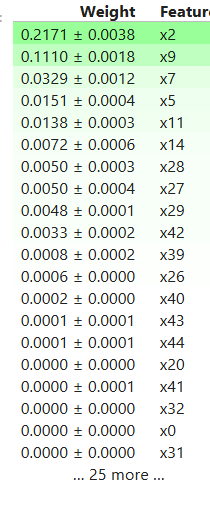

0: Age
1: Gender
2: Annual Income
3: Marital Status
4: Number of Dependents
5: Education Level
6: Occupation
7: Health Score
8: Location
9: Policy Type
10: Previous Claims
11: Vehicle Age
12: Credit Score
13: Insurance Duration
14: Policy Start Date
15: Customer Feedback
16: Smoking Status
17: Exercise Frequency
18: Property Type
19: Premium Amount
20: Policy_Start_Year
21: Policy_Start_Month
22: Policy_Start_Day
23: day_of_week
24: day_sin
25: day_cos
26: day_of_year
27: year_day_sin
28: year_day_cos
29: month
30: month_sin
31: month_cos
32: seconds_since_1970

In [55]:



# # Get the column names as a list
# column_names = X_train.columns.tolist()

# # Print the index number and column name for each column
# for i, column_name in enumerate(column_names):
#     print(f"{i}: {column_name}")

## Ensemble method (Stacking)

In [56]:
from sklearn.linear_model import Ridge
from sklearn.ensemble import StackingRegressor

base_estimators = [
    ('model1', cat_model),
    ('model2', light_model),
    ('model3', xgb_model),
    ('model4', hgbc_model)
]

stacking_model = StackingRegressor(estimators=base_estimators, final_estimator=Ridge())

stacking_model.fit(x_train, y_train)

ensemble_pred = stacking_model.predict(x_val)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


In [57]:
pred = ensemble_pred
y_val_true = np.expm1(y_val)
train_min = y_train.min()
clipped_predictions = np.maximum(pred, train_min)

print(rmsle(y_val_true, pred)) 

4.692049537161428


# Bias-Variance Tradeoff

Recently I started diving into bias-variance tradeoff, and one of the suggestions were to plot graph of residuals between model's predicted and true values. So, let's take a look

In [58]:
# pred = cat_model.predict(X_test_separated)
# # y_test_separated = (y_test_separated)
# residuals = y_test_separated-pred
# print(residuals)
# plt.scatter(y_test_separated, residuals)
# plt.axhline(y=0, color='red', linestyle='--')  # Лінія нульових залишків

# plt.show()

In [59]:
# sns.kdeplot(x=pred)

In [60]:
# sns.kdeplot(x=y_test_separated)

In [61]:
# from sklearn.model_selection import learning_curve

# train_sizes, train_scores, test_scores = learning_curve(cat_model, train_enc, y_log, cv=5)

# train_mean = np.mean(train_scores, axis=1)
# test_mean = np.mean(test_scores, axis=1)
# train_std = np.std(train_scores, axis=1)
# test_std = np.std(test_scores, axis=1)

# plt.plot(train_sizes, train_mean, label="Training score", color="blue")
# plt.plot(train_sizes, test_mean, label="Cross-validation score", color="green")
# plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="blue", alpha=0.2)
# plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="green", alpha=0.2)

# plt.title("Learning Curve (Bias-Variance Tradeoff)")
# plt.xlabel("Training Size")
# plt.ylabel("Score")
# plt.legend(loc="best")
# plt.grid(True)
# plt.show()

# CV score

After my posted discussion I decided not to follow public leaderboard, but instead follow cross validation and kfold score for models

In [62]:
def perform_cv_score(estimator, X, y, scoring):
    
    scores = cross_val_score(estimator, X=X, 
                             y=y,scoring=scoring, cv = 10, 
                             n_jobs=1,  error_score="raise")

    return scores

In [63]:
# data = {
#         "XGBRegressor": np.average(-1*perform_cv_score(xgb_model, train_enc, y_log, rmsle_scorer)),       
#        "LightGBM": np.average(-1*perform_cv_score(light_model, train_enc, y_log, rmsle_scorer)),
#         "CatBoost": np.average(-1*perform_cv_score(cat_model, train_enc, y_log, rmsle_scorer)),
#     'HistGradient': np.average(-1*perform_cv_score(hgbc_model, train_enc, y_log, rmsle_scorer)),
#     'StackingEnsemble': np.average(-1*perform_cv_score(stacking_model, train_enc, y_log, rmsle_scorer))
#        }

# data

# Submission

In [64]:
predictions = {
    'xgb': xgb_model.predict(test_enc),
    'light': light_model.predict(test_enc),
    'cat': cat_model.predict(test_enc),
    'hgbc': hgbc_model.predict(test_enc),
    'ensemble': stacking_model.predict(test_enc)
}

In [65]:
for key, pred in predictions.items():
    submission = pd.DataFrame({'id': id_test, 'Premium Amount': np.expm1(pred)})
    submission.to_csv(f"submission_insurance_{key}.csv", index=False)